## Data Preprocessing

To preprocess the California housing dataset for sequence-based learning, we need to transform it into a sequence-like structure that can be used for time-series or symbolic prediction


In [1]:
#loading the dataset
import pandas as pd
file_path= "C:/Users/lamin/OneDrive/Desktop/Datafolder/cali housing data/housing.csv"
df= pd.read_csv(file_path)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Choose Features for Prediction

From the dataset, select relevant features.

Predictor Variables: median_income, housing_median_age, latitude, longitude.
    
Target Variable: median_house_value.

In [2]:
predictors = ["median_income", "housing_median_age", "latitude", "longitude"]
target = "median_house_value"

In [3]:
# Drop missing values (if any)
import numpy as np
df.dropna(subset=predictors + [target], inplace=True)

## . Create a Sequential Structure

There is no inherent time dimension in the data so i created one by grouping by geographical regions and treat those groups as sequential data.

In [4]:
# Sort data by longitude to simulate a west-to-east progression
df= df.sort_values(by="longitude").reset_index(drop=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-124.35,40.54,52.0,1820.0,300.0,806.0,270.0,3.0147,94600.0,NEAR OCEAN
1,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0,NEAR OCEAN
2,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0,NEAR OCEAN
3,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0,NEAR OCEAN
4,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0,NEAR OCEAN


In [5]:
# Normalize the predictors and target for better training
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[predictors + [target]] = scaler.fit_transform(df[predictors + [target]])

## Create Input-Output Sequences for Ψₘ,ₖ

To prepare data for sequence learning, define sliding windows where:

m past samples are the input.

k future samples are the output.

In [6]:
import numpy as np

# Define sequence length (m) and prediction horizon (k)
m = 10  # Number of past samples to consider
k = 3  # Number of future samples to predict

# Select a numeric feature for prediction
feature = "median_house_value"
data = df[feature].values

# Create input-output sequences
X, y = [], []
for i in range(len(data) - m - k + 1):
    X.append(data[i:i + m])      # Past `m` samples
    y.append(data[i + m:i + m + k])  # Next `k` samples

# Convert to numpy arrays for modeling
X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (20628, 10)
Output shape: (20628, 3)


In [7]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output dataset shape for verification
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (16502, 10)
Shape of y_train: (16502, 3)
Shape of X_test: (4126, 10)
Shape of y_test: (4126, 3)


In [8]:
# Importing libries to train and evaluate the MLP Regressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [9]:
# Define the MLP regressor
def build_mlp_regressor(input_shape, output_units):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(output_units, activation="linear")  # Linear activation for regression
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

In [10]:
# Get the input shape and output units from the training data
input_shape = X_train.shape[1]
output_units = y_train.shape[1]

In [11]:
# Build the MLP model
model = build_mlp_regressor(input_shape=input_shape, output_units=output_units)

# Print the model summary to review the architecture
model.summary()

C:\Users\lamin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,859 (38.51 KB)

 Trainable params: 9,859 (38.51 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Now, we can train the model on the training data. During training, we can also monitor performance using the validation set

In [12]:
# Train the model on the training data
history = model.fit(X_train, y_train, 
                    epochs=50,        # Number of epochs to train
                    batch_size=32,    # Number of samples per gradient update
                    validation_split=0.2,  # 20% of training data for validation
                    verbose=1) 

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0616 - mae: 0.1820 - val_loss: 0.0410 - val_mae: 0.1543
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0449 - mae: 0.1584 - val_loss: 0.0408 - val_mae: 0.1543
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0425 - mae: 0.1542 - val_loss: 0.0413 - val_mae: 0.1483
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0432 - mae: 0.1548 - val_loss: 0.0405 - val_mae: 0.1521
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0419 - mae: 0.1531 - val_loss: 0.0407 - val_mae: 0.1497
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0417 - mae: 0.1526 - val_loss: 0.0407 - val_mae: 0.1500
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - mae: 0.1521 - val_loss: 0.0408 - val_mae: 0.1493
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0413 - mae: 0.1513 - val_loss: 0.0407 - val_mae: 0.1485
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

## Evaluate the Model

After training, we evaluate the model on the test data (X_test, y_test) to check its performance.

In [13]:
# Evaluate the model on the test data
loss, mae = model.evaluate(X_test, y_test)

print(f"Test Loss (MSE): {loss}")
print(f"Test MAE (Mean Absolute Error): {mae}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0402 - mae: 0.1524
Test Loss (MSE): 0.04073945805430412
Test MAE (Mean Absolute Error): 0.15279696881771088


## Make Predictions

Once the model is trained, you can use it to make predictions for future values.

In [14]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Print the first few predictions to check
print(predictions[:5])  # Display first 5 predictions

# Compare predicted vs true values (for the first few samples)
print(f"Predicted vs True (first 5 samples):")
for i in range(5):
    print(f"Predicted: {predictions[i]}  |  True: {y_test[i]}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[0.37823558 0.37101877 0.37601382]
 [0.23878175 0.24799582 0.25004908]
 [0.2943475  0.3018029  0.30468643]
 [0.22551313 0.23538134 0.23275937]
 [0.2660395  0.27516294 0.26506993]]
Predicted vs True (first 5 samples):
Predicted: [0.37823558 0.37101877 0.37601382]  |  True: [0.40391792 0.16309417 0.33175327]
Predicted: [0.23878175 0.24799582 0.25004908]  |  True: [0.18598068 0.18598068 0.35422741]
Predicted: [0.2943475  0.3018029  0.30468643]  |  True: [0.42103125 0.42494876 0.44886619]
Predicted: [0.22551313 0.23538134 0.23275937]  |  True: [0.20247545 0.26618653 0.23979489]
Predicted: [0.2660395  0.27516294 0.26506993]  |  True: [0.18824871 0.51731952 0.22453722]


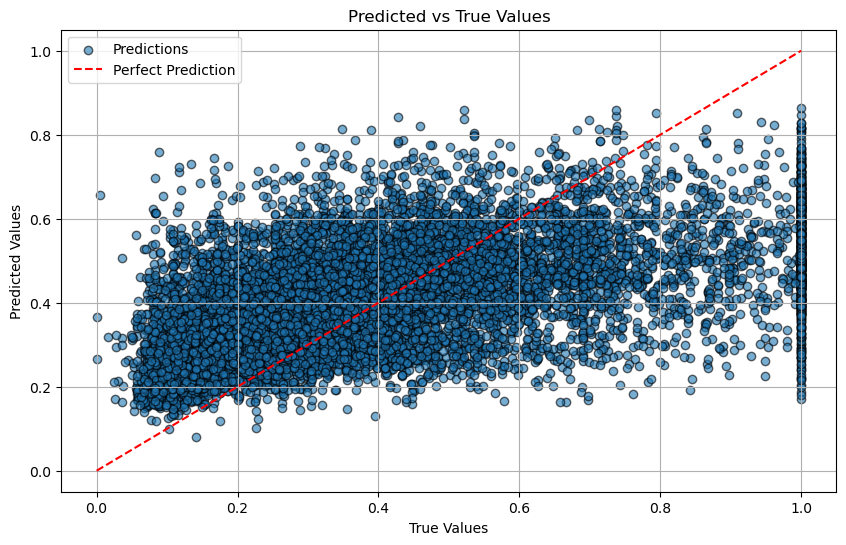

In [15]:
import matplotlib.pyplot as plt
# Ensure y_test is a numpy array for min/max operations
y_test = np.array(y_test)

# Plot Predicted vs True Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Prediction")
plt.title("Predicted vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

## Task 2

## 1. Data Preparation for Ψm, n, kΨm, n, k​
Data Preparation for Ψm, n, kΨm, n, k​

We will create sequences from your dataset for the Ψm, n, kΨm, n, k​ predictor. This process will:

    Extract nn past windows of size mm from your dataset.
    Set up targets for kk future steps.

In [16]:
# Assuming `data` is your dataset as a 1D numpy array
def create_sequences(data, m, n, k):
   
    X, y = [], []
    for i in range(len(data) - n * m - k):
        # Extract n windows of size m
        past_windows = data[i:i + n * m].reshape(n, m)
        # Flatten the past windows into a single array of size (n * m)
        X.append(past_windows.flatten())
        # Extract k future steps
        y.append(data[i + n * m:i + n * m + k])
    return np.array(X), np.array(y)


m, n, k = 5, 3, 2  # Customize these values based on your problem
X, y = create_sequences(data, m, n, k)

print(f"Input Shape (X): {X.shape}")  # Shape: (num_samples, n * m)
print(f"Output Shape (y): {y.shape}")  # Shape: (num_samples, k)


Input Shape (X): (20623, 15)
Output Shape (y): (20623, 2)


In [17]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output dataset shape for verification
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (16498, 15)
Shape of y_train: (16498, 2)
Shape of X_test: (4125, 15)
Shape of y_test: (4125, 2)


In [18]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (4125, 15)
y_test shape: (4125, 2)


##  update the Model for Ψm, n, kΨm, n, k

In [19]:
# Define the MLP regressor
def build_mlp_regressor(input_shape, output_units):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(output_units, activation="linear")  # Linear activation for regression
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Update input shape and output units
input_shape = X.shape[1]  # n * m
output_units = y.shape[1]  # k

# Build the model
model = build_mlp_regressor(input_shape=input_shape, output_units=output_units)
model.summary()


C:\Users\lamin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,434 (40.76 KB)

 Trainable params: 10,434 (40.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# train the model
history = model.fit(
    X, y,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0550 - mae: 0.1739 - val_loss: 0.0350 - val_mae: 0.1335
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0444 - mae: 0.1582 - val_loss: 0.0347 - val_mae: 0.1348
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0426 - mae: 0.1547 - val_loss: 0.0352 - val_mae: 0.1415
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0427 - mae: 0.1549 - val_loss: 0.0348 - val_mae: 0.1354
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0420 - mae: 0.1540 - val_loss: 0.0350 - val_mae: 0.1401
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0416 - mae: 0.1534 - val_loss: 0.0348 - val_mae: 0.1351
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0413 - mae: 0.1529 - val_loss: 0.0348 - val_mae: 0.1345
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0418 - mae: 0.1532 - val_loss: 0.0350 - val_mae: 0.1386
Epoch 9/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [21]:
#X_test, y_test = create_sequences(test_data, m, n, k)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE (Mean Absolute Error): {mae}")

# Predict future values
predictions = model.predict(X_test)

# Print sample predictions
print("Predicted vs True (first 5 samples):")
for i in range(5):
    print(f"Predicted: {predictions[i]} | True: {y_test[i]}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - mae: 0.1485
Test Loss (MSE): 0.03727714717388153
Test MAE (Mean Absolute Error): 0.14847728610038757
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted vs True (first 5 samples):
Predicted: [0.587059  0.5760231] | True: [0.90783337 1.        ]
Predicted: [0.21921319 0.22659206] | True: [0.2045373  0.15051691]
Predicted: [0.25503588 0.2608986 ] | True: [0.09958928 0.20103216]
Predicted: [0.2372257  0.24622235] | True: [0.29319673 0.37154692]
Predicted: [0.3040669  0.23016988] | True: [0.27237207 0.09216663]


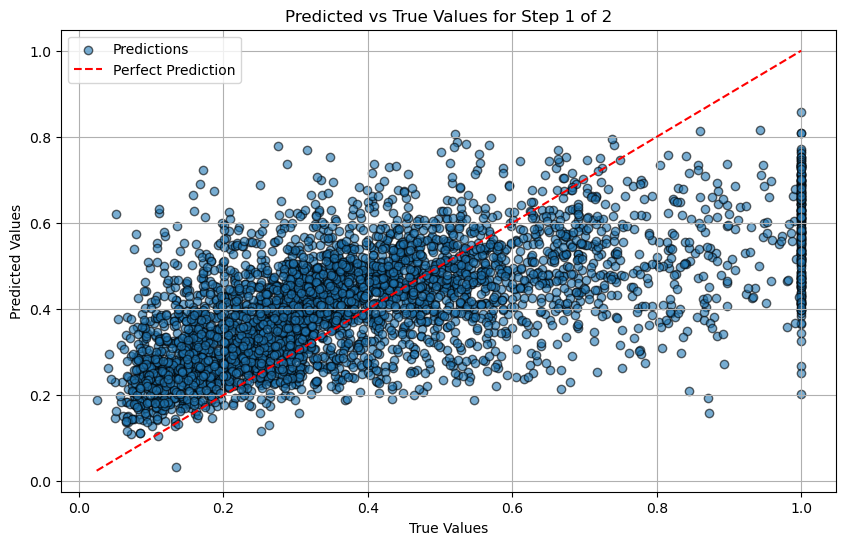

In [22]:
# Visualize predictions vs true values for the first predicted step
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:, 0], predictions[:, 0], alpha=0.6, edgecolor='k', label="Predictions")
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], 
         [y_test[:, 0].min(), y_test[:, 0].max()], 
         color='red', linestyle='--', label="Perfect Prediction")
plt.title(f"Predicted vs True Values for Step 1 of {k}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()